# Advanced ML: Домашнее задание 1

*Это задание связано с анализом конкретного датасета, в котором, надеюсь, понадобится то, чему мы с вами до сих пор научились. В качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему в этом ноутбуке категорически приветствуются. Датасет давайте возьмём довольно релевантный реальной жизни; он доступен по следующей ссылке:*

[Ссылка на данные](https://ourworldindata.org/coronavirus-source-data)

1. Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

2. Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.
   * a. Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.
   
   * b. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).
   
   * c. Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).
3. Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:
$$\large{Ф(x) = \frac{1}{\sqrt{2\pi}}\int\limits_{-\infty}^x e^{-\frac{t^2}{2}}\,dt}$$

    Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.
   * a. Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.
   
   * b. Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.
   
   * c. Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?
   
4. *Бонус: проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

5. *[Эта часть задания не оценивается, здесь нет правильных и неправильных ответов, но буду рад узнать, что вы думаете]
Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам такого моделирования? Как принять решение, например, о том, нужно ли вводить карантин?


# Решение

---
# 1. Задание

Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from datetime import datetime, timedelta

In [8]:
sns.set_style("whitegrid")
palette = sns.color_palette()
figsize = (15, 8)
legend_fontsize = 18
axis_fontsize = 16

In [9]:
data = pd.read_csv("owid-covid-data.csv")
data['date'] = pd.to_datetime(data['date'])
data = data[(data.location == 'Russia') & (data.date >= '2020-03-03')]
data = data.replace({'new_cases' : {0.0 : 1.0}})

date_of_separation = data.iloc[0].date + pd.Timedelta("50 day")

data['day'] = np.arange(1, data.shape[0] + 1)

train = data[data.date < date_of_separation]
test = data[data.date >= date_of_separation]

limit_days = 1e6

print(train.shape)
print(test.shape)

(50, 68)
(1042, 68)


In [10]:
data.head(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,day
192154,RUS,Europe,Russia,2020-03-03,3.0,1.0,0.143,NaN,NaN,NaN,...,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN,1
192155,RUS,Europe,Russia,2020-03-04,3.0,1.0,0.143,NaN,NaN,NaN,...,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN,2
192156,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,NaN,...,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN,3
192157,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,NaN,...,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN,4
192158,RUS,Europe,Russia,2020-03-07,13.0,1.0,1.571,NaN,NaN,NaN,...,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN,5


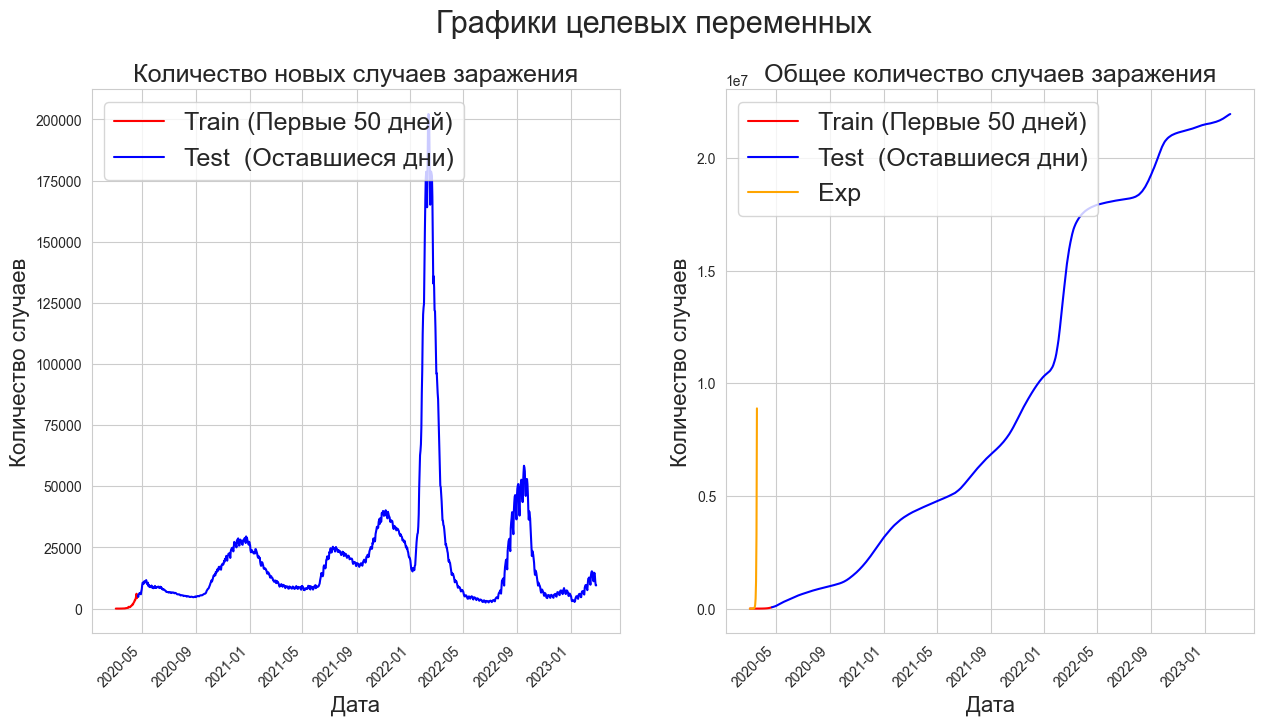

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
fig.autofmt_xdate(rotation=45)
fig.suptitle("Графики целевых переменных", fontsize=legend_fontsize + 4)

ax[0].plot(train.date, train.new_cases, label="Train (Первые 50 дней)", color='red')
ax[0].plot(test.date, test.new_cases, label="Test  (Оставшиеся дни)", color='blue')
ax[0].set_title("Количество новых случаев заражения", fontsize=legend_fontsize)
ax[0].set_xlabel("Дата", fontsize=axis_fontsize)
ax[0].set_ylabel("Количество случаев",  fontsize=axis_fontsize)
ax[0].legend(loc="upper left", fontsize=legend_fontsize)

ax[1].plot(train.date, train.total_cases, label="Train (Первые 50 дней)", color='red')
ax[1].plot(test.date, test.total_cases, label="Test  (Оставшиеся дни)", color='blue')
ax[1].plot(data.date[:17], np.exp(range(17)), label="Exp", color='orange')
ax[1].set_title("Общее количество случаев заражения", fontsize=legend_fontsize)
ax[1].set_xlabel("Дата", fontsize=axis_fontsize)
ax[1].set_ylabel("Количество случаев", fontsize=axis_fontsize)
ax[1].legend(loc="upper left", fontsize=legend_fontsize)

plt.show()

### Вывод: 
На графике виден рост общего количества случаев заражения похожий на экспоненциальных

---
# Задание 2

Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

## Задание 2.1 

Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

In [13]:
from sklearn.linear_model import LinearRegression


lr_model = LinearRegression()

X_train = train['day'].values.reshape(-1, 1)
X_test = test['day'].values.reshape(-1, 1)

Y_train = np.log(train["total_cases"]).values.reshape(-1, 1)
Y_test = np.log(test["total_cases"]).values.reshape(-1, 1)

lr_model.fit(X_train, Y_train)
lr_pred = lr_model.predict(X_test)

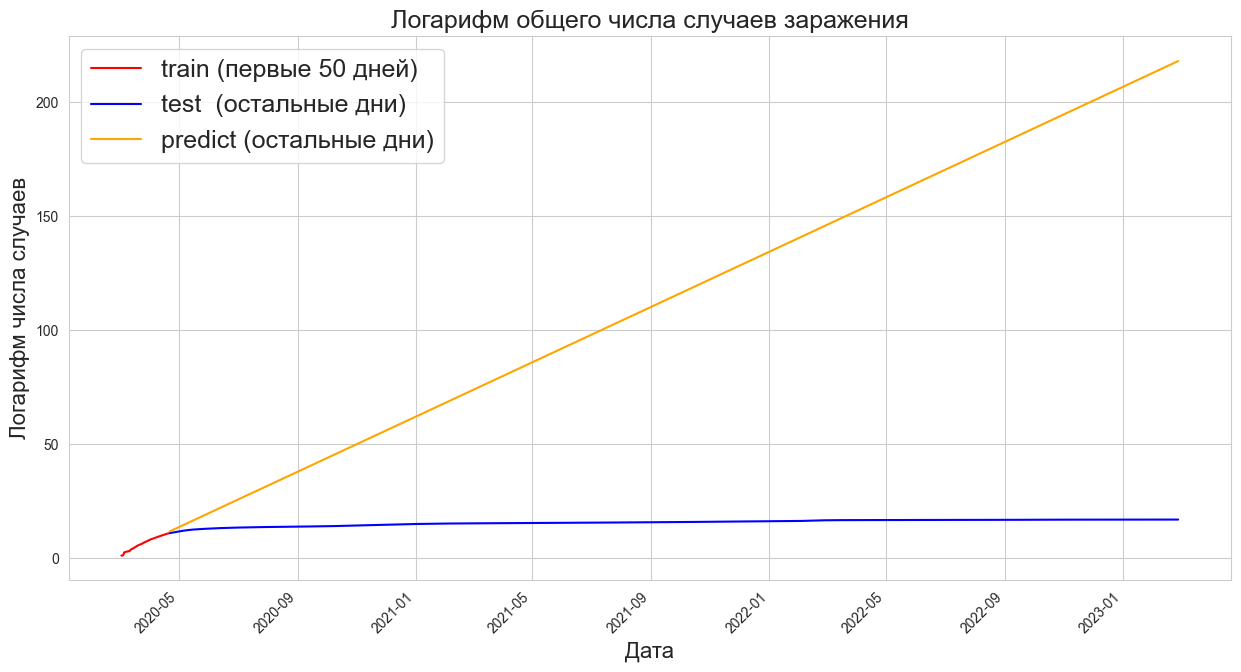

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
fig.autofmt_xdate(rotation=45)

ax.margins(0.05)
ax.plot(train.date, Y_train , label="train (первые 50 дней)", color='r')
ax.plot(test.date, Y_test, label="test  (остальные дни)", color='b')
ax.plot(test.date, lr_pred, label="predict (остальные дни)", color='orange')
ax.set_title("Логарифм общего числа случаев заражения", fontsize=legend_fontsize)
ax.set_xlabel("Дата", fontsize=axis_fontsize)
ax.set_ylabel("Логарифм числа случаев", fontsize=axis_fontsize)
ax.legend(loc="upper left", fontsize=legend_fontsize)

plt.show()

### Вывод:
Как видно из графика предсказания модели далеки от идеальных или даже приемлемых

## Задание 2.2

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [15]:
sigma_noise = np.std(lr_model.predict(X_train) - Y_train)
print(sigma_noise)

0.3490422059635659


In [16]:
N = 1000
X = np.linspace(1.4, 1.8, N)
Y = np.linspace(0, 0.4, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

In [17]:
def plot_heatmap(Z):
    plt.axis('equal')
    plt.xlim((1.4, 1.8))
    plt.ylim((0, 0.4))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.float64(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix)))
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [18]:
cur_mu = np.array([0, 0])
cur_sigma = np.array([[5, 0], [0, 5]])

for i in range(train.shape[0]):
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma,
                                        train.iloc[i]['day'], np.log(train.iloc[i]['total_cases']),
                                        sigma_noise=sigma_noise)

In [19]:
print("Апостериорное распределение параметров этой модели:\n")
print("mu = {}\n".format(cur_mu))
print("sigma = {}".format(cur_sigma))

Апостериорное распределение параметров этой модели:

mu = [1.61920516 0.19838707]

sigma = [[ 1.00246404e-02 -2.97761426e-04]
 [-2.97761426e-04  1.16826091e-05]]


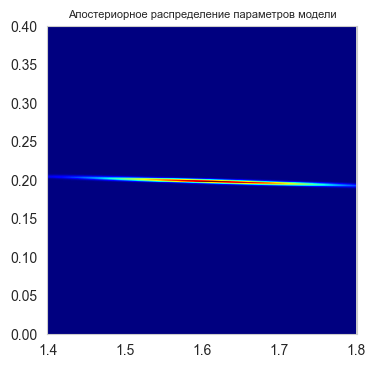

In [20]:
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
ax.set_xlim((1.4, 1.8))
ax.set_ylim((0, 0.4))
ax.set_title("Апостериорное распределение параметров модели", fontsize=8)
plot_heatmap(Z)

## Задание 2.3 
    
Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [21]:
x_all = data['day'].values.reshape(-1, 1)
y_all = data['total_cases'].values.reshape(-1, 1)

def get_samples_from_dist(mu: np.ndarray, 
                          sigma: np.ndarray, 
                          start: float = 0, 
                          end: float = 50, 
                          n: int = 50, 
                          resolution: int = 400):
    '''График сэмплированных прямых из распределения параметров'''
    sample_exponents = []
    my_w = np.random.multivariate_normal(cur_mu, cur_sigma, end)
    for w in my_w:
        sample_exponents.append(np.exp(w[0] + w[1] * x_all))
    sample_exponents = np.array(sample_exponents)
    
    return sample_exponents


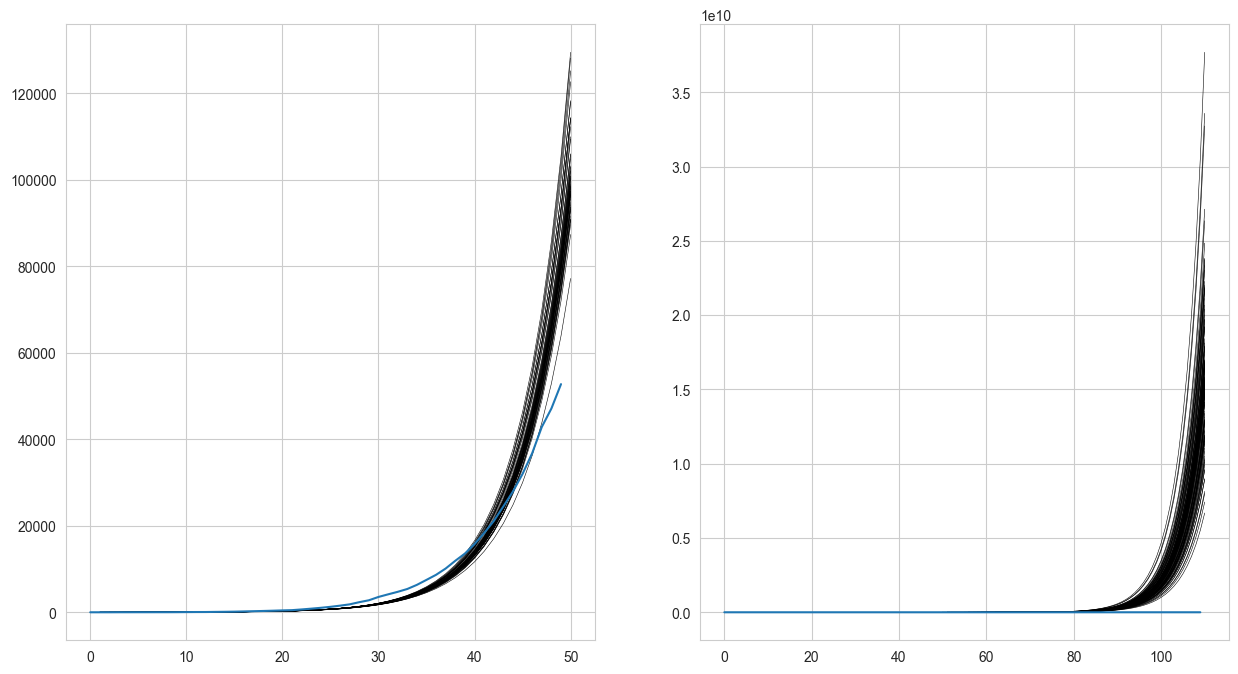

In [22]:
threshold = [50, 110]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
for ind, thr in enumerate(threshold):
    samples = get_samples_from_dist(cur_mu, 
                                        cur_sigma, 
                                        end=thr)
    for sample in samples:
        ax[ind].plot(x_all[:thr], sample[:thr], 'k-', lw=.4)
    ax[ind].plot(range(thr), data.total_cases[:thr])  


plt.show()

In [23]:
start_date = datetime(2020, 3, 3) 

may = datetime(2020, 5, 1)
june = datetime(2020, 6, 1)
september = datetime(2020, 9, 1)

day_to_may = (may - start_date).days
day_to_june = (june - start_date).days
day_to_september = (september - start_date).days

indices = [day_to_may, day_to_june, day_to_september]
print(f"Индексы дней: {indices}")
samples = get_samples_from_dist(cur_mu, 
                                cur_sigma, 
                                end=indices[-1], 
                                n=5000)

Индексы дней: [59, 90, 182]


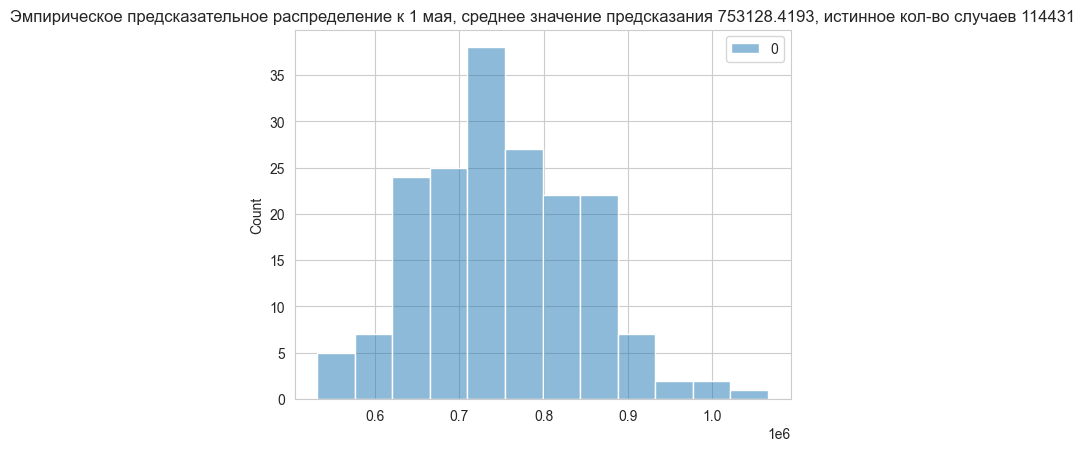

In [24]:
mean = samples[:, indices[0]].mean().round(4)
title = f"Эмпирическое предсказательное распределение к 1 мая, среднее значение предсказания {mean}, истинное кол-во случаев {int(data.loc[data['date'] == may].total_cases)}"
sns.histplot(samples[:, indices[0]]).set_title(title);

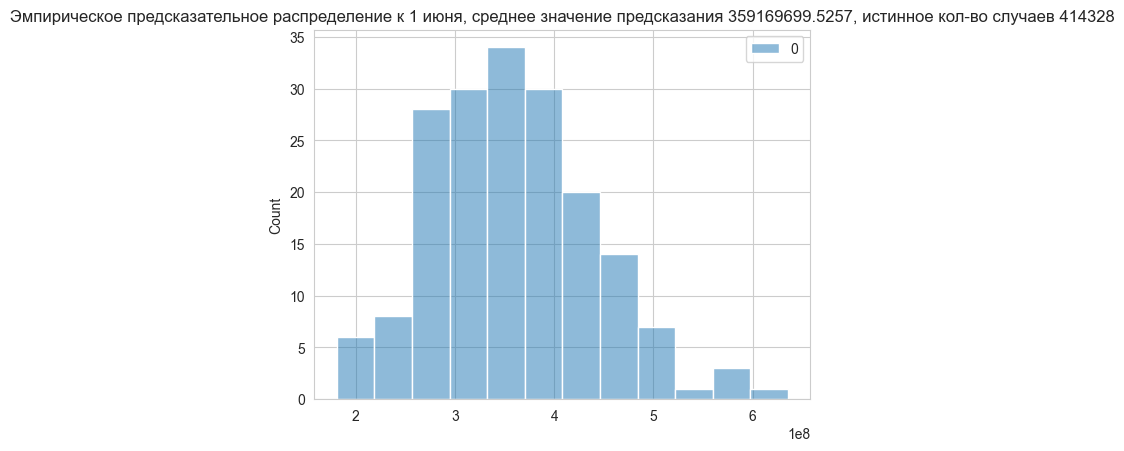

In [25]:
mean = samples[:, indices[1]].mean().round(4)
title = f"Эмпирическое предсказательное распределение к 1 июня, среднее значение предсказания {mean}, истинное кол-во случаев {int(data.loc[data['date'] == june].total_cases)}"
sns.histplot(samples[:, indices[1]]).set_title(title);


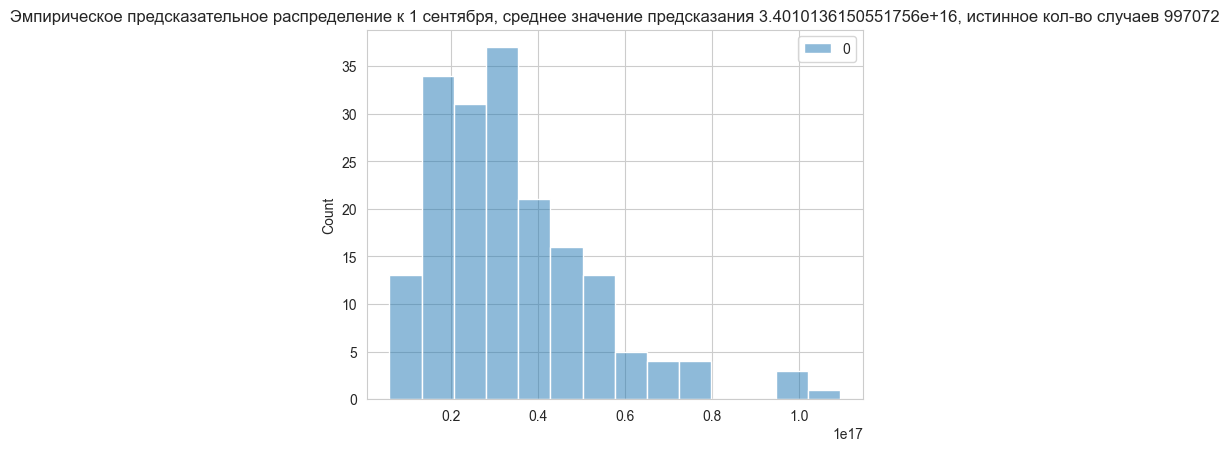

In [26]:
mean = samples[:, indices[2]].mean().round(4)
title = f"Эмпирическое предсказательное распределение к 1 сентября, среднее значение предсказания {mean}, истинное кол-во случаев {int(data.loc[data['date'] == september].total_cases)}"
sns.histplot(samples[:, indices[2]]).set_title(title);

---
## Задание 3

Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:
    
$$\large{Ф(x) = \frac{1}{\sqrt{2\pi}}\int\limits_{-\infty}^x e^{-\frac{t^2}{2}}\,dt}$$

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

## Задание 3.1 

Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Заметим, что приращение количества часла заболевших $\frac{d\ total\_cases}{dx}$ это количество новых случаев $new\_cases$. Продифференцируем и прологарифмируем левую и правую части равенства 
$$\large{total\_cases = \int\limits_{-\infty}^x e^{w_2t^2 + w_1t + w_0}\,dt}$$ получим:

$$\ln({new\_cases}) = w_2t^2 + w_1t + w_0 $$

Тогда для предсказания $total\_cases$ нужно:
1. Обучить линейную регрессию предсказывать логирифм от количества новых случаев
2. Для предсказания общего числа заболевших в определенный день просуммировать экспоненты от полученных предсказаний за все предшествующие дни

## Задание 3.2
Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [27]:
lr_model2 = LinearRegression()

data['day2'] = data['day']**2

train = data[data.date < date_of_separation]
test = data[data.date >= date_of_separation]

lr_model2.fit(train[['day', 'day2']], np.log(train['new_cases']))

LinearRegression()

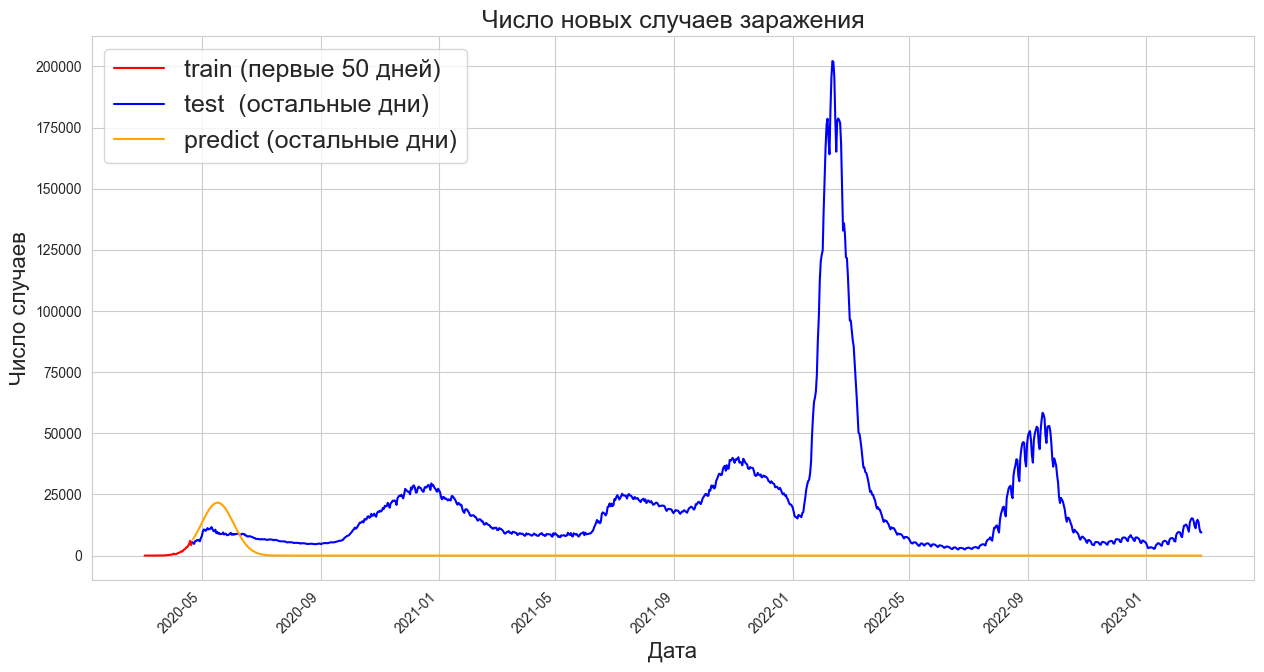

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
fig.autofmt_xdate(rotation=45)

ax.plot(train.date, train['new_cases'], label="train (первые 50 дней)", color='r')
ax.plot(test.date, test['new_cases'], label="test  (остальные дни)", color='b')
ax.plot(test.date, np.exp(lr_model2.predict(test[['day', 'day2']])), label="predict (остальные дни)", color='orange')
ax.set_title("Число новых случаев заражения", fontsize=legend_fontsize)
ax.set_xlabel("Дата", fontsize=axis_fontsize)
ax.set_ylabel("Число случаев", fontsize=axis_fontsize)
ax.legend(loc="upper left", fontsize=legend_fontsize)

plt.show()

In [29]:
sigma_noise = np.std(lr_model2.predict(train[['day', 'day2']]) - np.log(train['new_cases']))
sigma_noise

0.4891695424595195

In [30]:
N = 1000
X = np.linspace(0, 0.4, N)
Y = np.linspace(0, 0.4, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
    
cur_mu = np.array([0, 0, 0])
cur_sigma = np.array([[50, 0, 0], [0, 50, 0], [0, 0, 50]])

def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x, x**2]])
    sigma_n = np.linalg.inv(np.float64(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix)))
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

for i in range(train.shape[0]):
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma,
                                        train.iloc[i]['day'], np.log(train.iloc[i]['new_cases']),
                                        sigma_noise=sigma_noise)

In [31]:
print("Апостериорное распределение параметров этой модели:\n")
print("mu = {}\n".format(cur_mu))
print("sigma = {}".format(cur_sigma))

Апостериорное распределение параметров этой модели:

mu = [-0.67339328  0.27923046 -0.00182893]

sigma = [[ 4.66658995e-02 -3.69569846e-03  6.09850687e-05]
 [-3.69569846e-03  3.81916385e-04 -7.03880677e-06]
 [ 6.09850687e-05 -7.03880677e-06  1.38029897e-07]]


## Задание 3.3 
Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [32]:
samples.shape

(182, 1092, 1)

Text(0.5, 1.0, 'Общее число случаев заражения и сэмплированные сигмоиды')

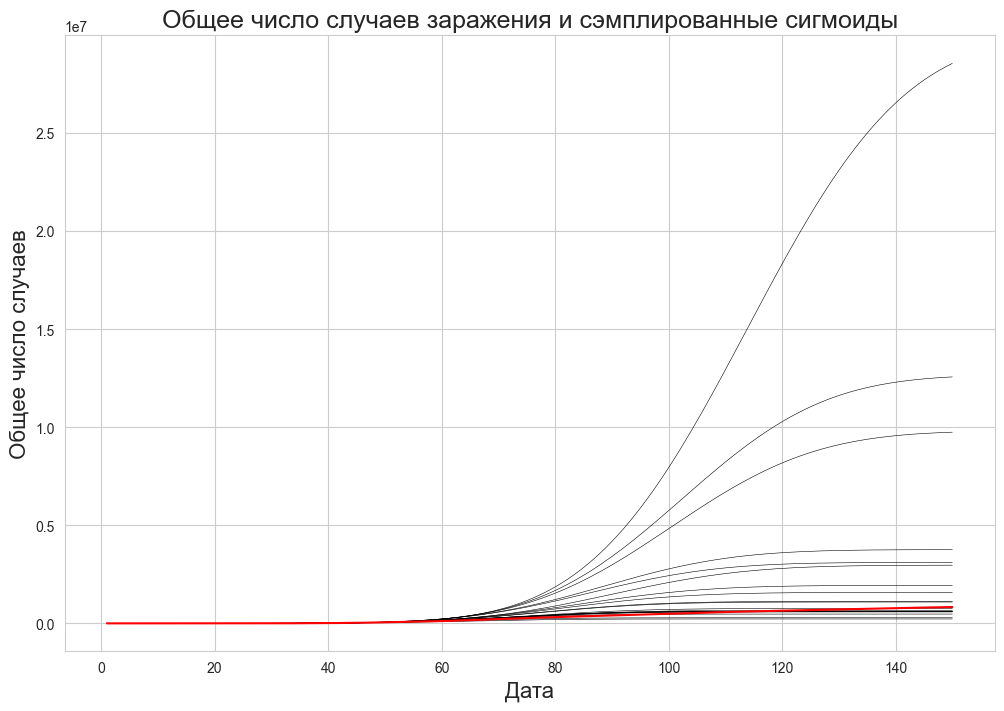

In [33]:
x_first = data['day'].values.reshape(-1, 1)[:150]
y_first = data['total_cases'].values.reshape(-1, 1)[:150]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
my_w = np.random.multivariate_normal(cur_mu, cur_sigma, 20)
for w in my_w:
    ax.plot(x_first, np.cumsum(np.exp(w[0] + w[1] * x_first + w[2] * (x_first**2))), 'k-', lw=.4)
    
ax.plot(x_first, y_first, color='r')
ax.set_xlabel("Дата", fontsize=axis_fontsize)
ax.set_ylabel("Общее число случаев", fontsize=axis_fontsize)
ax.set_title("Общее число случаев заражения и сэмплированные сигмоиды", fontsize=legend_fontsize)

In [34]:
def get_samples_from_dist(mu, sigma, num_days, n=200, e_s=7):
    days = np.arange(0, num_days, 1)

    y_lim = [0, np.power(10, e_s)]
    x_lim = [0, num_days]
    xs = np.linspace(0, num_days, n)
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    samples = []
    for w in my_w:
        preds = np.cumsum(np.exp(w[0] + w[1] * xs + w[2] * xs ** 2))
        # plt.plot(xs, preds, 'k-', lw=0.4, alpha=0.2, color='dimgray')
        samples.append(preds)
    samples = np.array(samples)
    return samples[:, -1]

def hist_plot(data, date):
    optimistic_pred = np.quantile(data, 0.1)
    pessimistic_pred = np.quantile(data, 0.9)

    plt.figure(figsize=(9, 9))
    sns.histplot(data, bins=100, kde=True)
    plt.xlabel("количество заболевших")
    plt.ylabel("Число семплов")
    plt.title(f"Количество заболевших на  {date}")
    plt.grid(True)
    plt.show()
    print(f"на  {date}")
    print(f'10-й процентиль (оптимистическая оценка): {optimistic_pred:,.0f}')
    print(f'90-й процентиль (песимистическая оценка): {pessimistic_pred :,.0f}')

In [35]:
n_samples = 1000

samples_may = get_samples_from_dist(cur_mu, cur_sigma, n=n_samples, num_days=day_to_may)
samples_june = get_samples_from_dist(cur_mu, cur_sigma, n=n_samples, num_days=day_to_june)
samples_september = get_samples_from_dist(cur_mu, cur_sigma, n=n_samples, num_days=day_to_september)

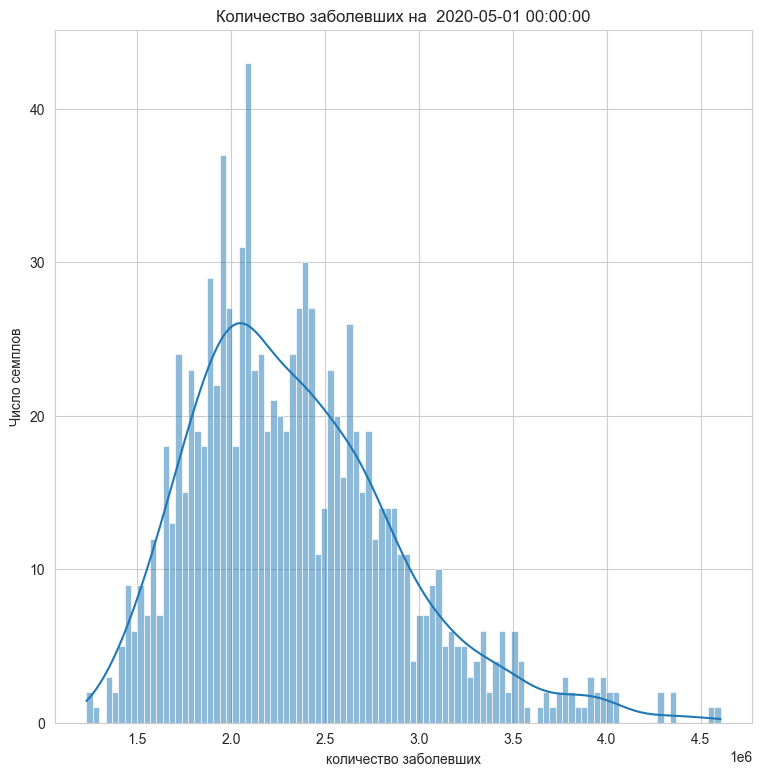

на  2020-05-01 00:00:00
10-й процентиль (оптимистическая оценка): 1,713,857
90-й процентиль (песимистическая оценка): 3,083,500


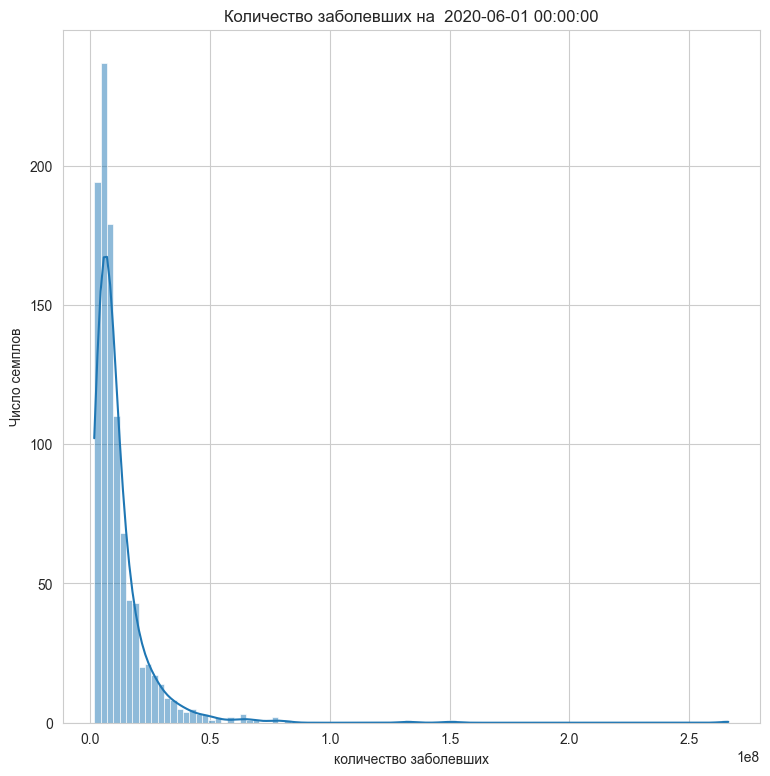

на  2020-06-01 00:00:00
10-й процентиль (оптимистическая оценка): 3,336,859
90-й процентиль (песимистическая оценка): 23,545,583


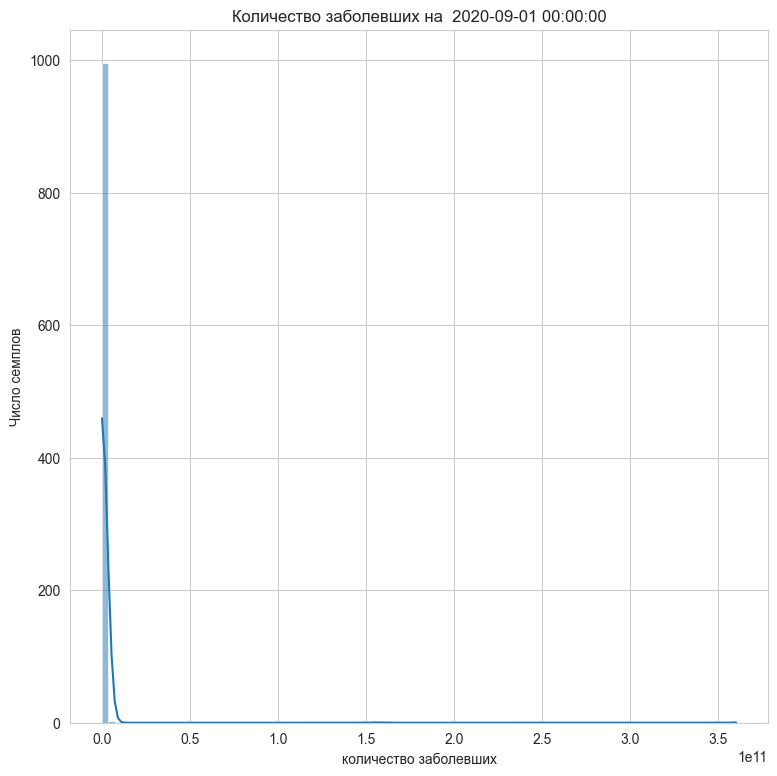

на  2020-09-01 00:00:00
10-й процентиль (оптимистическая оценка): 1,699,487
90-й процентиль (песимистическая оценка): 26,790,847


In [36]:
hist_plot(samples_may, data.loc[data.date == may]["date"].tolist()[0])
hist_plot(samples_june, data.loc[data.date == june]["date"].tolist()[0])
hist_plot(samples_september, data.loc[data.date == september]["date"].tolist()[0])